In [1]:
! pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.multiprocessing as mp

import gym
import os
from torch import nn
import torch
import numpy as np
import pickle


In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from gym import spaces

In [4]:
# Wind noise function
def wind_noise(action):
  wind_direction = np.random.randint(0, 3)
  double_action = False
  
  if wind_direction == 0:  
    wind_action = action

  elif wind_direction == 1 and action == 0:
    wind_action = 0  
    double_action = True


  elif wind_direction == 2 and action == 1:
    wind_action = 1  
    double_action = True
    
  else:
    wind_action = action

  return double_action, wind_action

def modified_env_step(environment, action):
    double_action, wind_action = wind_noise(action)

    if not double_action:
        observation, reward, terminated, info = environment.step(wind_action)
    else:
        observation, reward1, terminated, info = environment.step(action)
        observation, reward2, terminated, info = environment.step(wind_action)
        reward = reward1 + reward2

    return observation, reward, terminated, info

environment = gym.make('CartPole-v1')
observation = environment.reset()

action = environment.action_space.sample()

observation, reward, terminated, info = modified_env_step(environment, action)

print(observation, reward, terminated, info)


[-0.04272718  0.21924527 -0.04693168 -0.34428436] 1.0 False {}


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
class CartPoleWind(gym.Env):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def step(self, action):
        return modified_env_step(self.env, action)

    def reset(self):
        return self.env.reset()

    def render(self, mode='human'):
        return self.env.render(mode)

    def close(self):
        return self.env.close()

In [6]:


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

def convert_to_tensor(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    return state

def select_action(actor_critic, state):
    state = convert_to_tensor(state)
    action_probs, _ = actor_critic(state)
    arrange_action_probs = np.arange(len(action_probs[0]))
    action = np.random.choice(arrange_action_probs, p=action_probs.detach().numpy()[0])
    return action

def evaluate_action(actor_critic, state):
    state = convert_to_tensor(state)
    with torch.no_grad():
        value, action_probs = actor_critic(state)
    action = torch.argmax(action_probs).item()
    return action

def optimize_model(actor_critic, state, action, reward, next_state, done, optimizer, gamma):
    state = convert_to_tensor(state)
    next_state = convert_to_tensor(next_state)
    reward = torch.tensor([reward], dtype=torch.float32)
    done = torch.tensor([1 - int(done)], dtype=torch.float32)

    _, value = actor_critic(state)
    _, next_value = actor_critic(next_state)

    target = reward + gamma * next_value * done
    td_error = target - value

    action_probs, _ = actor_critic(state)
    log_prob = torch.log(action_probs.squeeze(0)[action])
    actor_loss = -log_prob * td_error.detach()

    critic_loss = td_error.pow(2)

    loss = actor_loss + critic_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def train_a3c(env, gamma, lr, max_episodes):

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    actor_critic = ActorCritic(state_dim, action_dim)
    actor_critic.share_memory()
    optimizer = optim.Adam(actor_critic.parameters(), lr=lr)

    num_processes = mp.cpu_count()
    processes = []
    for rank in range(num_processes):
        p = mp.Process(target=run_a3c, args=(rank, actor_critic, env, gamma, lr, max_episodes))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()

    with open('episode_rewards.pkl', 'rb') as f:
        episode_rewards = pickle.load(f)
    with open('avg_rewards.pkl', 'rb') as f:
        avg_reward_list = pickle.load(f)

    plt.plot(episode_rewards, 'g', label='Reward')
    plt.plot(avg_reward_list, 'r', label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.title('Rewards Per Episode')
    plt.grid()
    plt.legend()
    plt.show()


    # plt.plot(np.arange(len(avg_reward_list)), avg_reward_list)
    # plt.xlabel('Episode')
    # plt.ylabel('Average Reward')
    # plt.title('Average Reward per Episode')
    # plt.show()

    torch.save(actor_critic.state_dict(), 'actor_critic_noise.pt')
    print('Model saved.')



In [8]:

def run_a3c(rank, actor_critic, env_name, gamma, lr, max_episodes):
    env.seed(rank)
    torch.manual_seed(rank)

    optimizer = optim.Adam(actor_critic.parameters(), lr=lr)

    episode_rewards = []
    avg_reward_list = []
    for episode in range(max_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = select_action(actor_critic, state)
            env_list = env.step(action)
            next_state = env_list[0]
            reward = env_list[1]
            done = env_list[2]
            _ = env_list[3]
            total_reward += reward

            optimize_model(actor_critic, state, action, reward, next_state, done, optimizer, gamma)
            state = next_state

        episode_rewards.append(total_reward)
      
        avg_reward_list.append(sum(episode_rewards)/len(episode_rewards))
        if len(episode_rewards) >= 100:
            avg_reward = np.mean(episode_rewards[-100:]) 
            if rank == 0:
                print(f"Episode {episode}, Reward: {total_reward}, Avg Reward: {avg_reward}")


            with open('episode_rewards_noise.pkl', 'wb') as f:
                pickle.dump(episode_rewards, f)
            with open('avg_rewards_noise.pkl', 'wb') as f:
                pickle.dump(avg_reward_list, f)
                

            if avg_reward >= 500:
                if rank == 0:
                    print(f"Solved at episode {episode}: average reward of last 100 episodes is {avg_reward}")
                    torch.save(actor_critic.state_dict(), 'actor_critic_noise.pt')
                    print('Model saved.')
                break

    env.close()




/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'rese

Episode 99, Reward: 17.0, Avg Reward: 32.13
Episode 100, Reward: 48.0, Avg Reward: 32.5
Episode 101, Reward: 48.0, Avg Reward: 32.88
Episode 102, Reward: 133.0, Avg Reward: 34.12
Episode 103, Reward: 110.0, Avg Reward: 35.11
Episode 104, Reward: 50.0, Avg Reward: 35.46
Episode 105, Reward: 104.0, Avg Reward: 36.39
Episode 106, Reward: 127.0, Avg Reward: 37.5
Episode 107, Reward: 48.0, Avg Reward: 37.89
Episode 108, Reward: 35.0, Avg Reward: 38.14
Episode 109, Reward: 49.0, Avg Reward: 38.53
Episode 110, Reward: 56.0, Avg Reward: 38.96
Episode 111, Reward: 65.0, Avg Reward: 39.49
Episode 112, Reward: 48.0, Avg Reward: 39.81
Episode 113, Reward: 43.0, Avg Reward: 40.13
Episode 114, Reward: 48.0, Avg Reward: 40.5
Episode 115, Reward: 48.0, Avg Reward: 40.87
Episode 116, Reward: 95.0, Avg Reward: 41.71
Episode 117, Reward: 76.0, Avg Reward: 42.38
Episode 118, Reward: 67.0, Avg Reward: 42.48
Episode 119, Reward: 153.0, Avg Reward: 43.83
Episode 120, Reward: 74.0, Avg Reward: 44.4
Episode 12

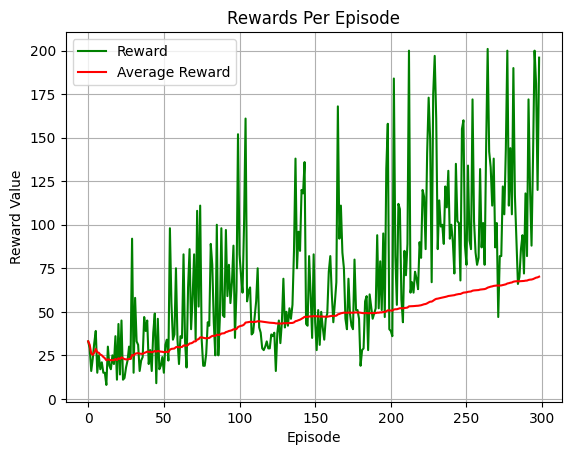

Model saved.


In [36]:

env = CartPoleWind()
train_a3c(env, gamma=0.99, lr=0.001, max_episodes=500)




/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


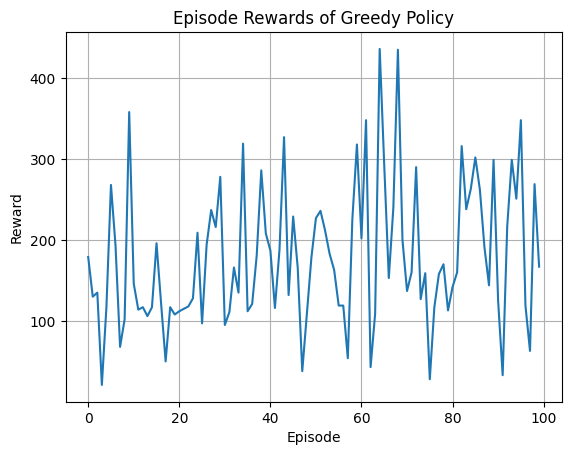

In [8]:
import pickle
import matplotlib.pyplot as plt
import torch
env = CartPoleWind()
def evaluate_model(model, env, num_episodes):
    episode_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
          action = select_action(model, state)
          env_list = env.step(action)
          observation = env_list[0]
          reward = env_list[1]
          done = env_list[2]
          _ = env_list[3]
          total_reward += reward
        # while not done:
        #     state = torch.from_numpy(state).float().unsqueeze(0)
        #     with torch.no_grad():
        #         value, action_probs = evaluate_action(state)
        #     action = torch.argmax(action_probs).item()
            # with torch.no_grad():
            #     # state_tensor = torch.FloatTensor(state)
            #     # action_probs = model(state_tensor)
            #     # print(type(action_probs))
            #     # action = torch.argmax(action_probs).item()
          env_list = env.step(action)
          next_state = env_list[0]
          reward = env_list[1]
          done = env_list[2]
          _ = env_list[3]
          total_reward += reward
          state = next_state
        episode_rewards.append(total_reward)
    return episode_rewards


model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
model.load_state_dict(torch.load('actor_critic_noise.pt'))


env = CartPoleWind()
episode_rewards = evaluate_model(model, env, num_episodes=100)

with open('episode_rewards_eval_noise.pkl', 'wb') as f:
    pickle.dump(episode_rewards, f)


plt.figure()
plt.plot(episode_rewards)
plt.title("Episode Rewards of Greedy Policy")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()
